# Data Analysis Horizontal Model

## 0. Setting up

#### Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import math
from scipy import special
import bisect
from statistics import mean
from cycler import cycler
import pickle
from matplotlib.pyplot import figure
from cgi import test
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import optimize
from scipy.integrate import solve_ivp
import csv

#### Parameters

In [2]:
l0_folded = 1
lb = 1
kappab = 0.25
k_BT = 4.114 
l_b = 1 
e_b = 1.5  
kappa = .25 
sigma_b = math.sqrt(k_BT / 0.25) 
Delta = 10 
Delta1 = 5
Delta2 = 5
e_f = 0.5 
k_beta = 1
k_delta = 1
F0 = k_BT/ math.sqrt(k_BT )

#### List of labels, colors etc. for plotting

In [3]:
labels_mean = [r'$\langle n_a \rangle $', r'$\langle n_{b} \rangle$', r'$\langle n_{a_u} \rangle$', r'$\langle n_{b_u} \rangle$' ]
labels = [r'$n_a$', r'$n_b$', '$n_{a_u}$', '$n_{b_u}$']

colors_occupationnumbers = [ 'teal', 'g', 'c', 'lightgreen']
colors_blues = ['skyblue', 'deepskyblue', 'dodgerblue', 'royalblue', 'blue','mediumblue','darkblue',  'midnightblue','k']
color_new = ['red','darkorange','goldenrod', 'y', 'palegreen','g','teal', 'c', 'paleturquoise',  'lightblue']  

## 1. Load dictionaries

In [37]:
gp = 20
gm = 1
ximin = 0
ximax = 0.2
fmin = 0
fmax = 80
fstep = 4
noreactions = 600000
d = 2

forces = [i for i in range(0, 81, 4)]
lst = [0, 0.05 , 0.1, 0.15, 0.2]

#### Simulation data
For generate entire trajectories use 'HorizontalModel-ParallelizedForce.ipynb' or 'HorizontalModel-ParallelizedXi.ipynb'. This allwos to compute the mean occupation numbers in steady state and the velocity of the boundary (done in the following).

In [260]:
with open(f'FORCE_xi{ximin}-{ximax}_gp{gp}_gm{gm}_f{fmin}-{fmax}-{fstep}_molinit100-60-20-10_noreac{noreactions}_F0-1.pkl', 'rb') as f:
    dict_trajectory = pickle.load(f)

#### Occupation numbers, velocities, correction terms
Load dictionary for plotting

In [38]:
with open(f'MeanOcc_SteadyState_xi{ximin}-{ximax}_gp{gp}_gm{gm}_f{fmin}-{fmax}-{fstep}_molinit100-60-20-10_noreac{noreactions}_F0-1.pkl', 'rb') as f:
    dict = pickle.load(f)    
    
with open('OrderCorrections_gp10-20_gm1.pkl', 'rb') as f:
    dict_analytic = pickle.load(f)

with open(f'MeanVelocity_SteadyState_xi{ximin}-{ximax}_gp{gp}_gm{gm}_f{fmin}-{fmax}-{fstep}_molinit100-60-20-10_noreac{noreactions}_F0-1.pkl', 'rb') as f:
    dict_velo = pickle.load(f)

## 2. Compute mean velocity

#### Plot single trajectory to determine time when system is in steady state

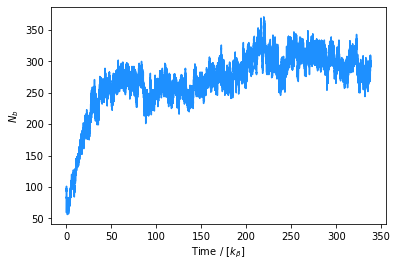

In [262]:
xi = 0.2
f= 80

plt.plot(dict_trajectory.get(f'xi{xi}_f{f}_time'), dict_trajectory.get(f'xi{xi}_f{f}_occ')[1], color = 'dodgerblue')
plt.xlabel(r'Time / [$k_{\beta}$]')
plt.ylabel(r'$N_b$')
plt.show()

#### Determine Index $\textit{k}$ when Steady State starts 

In [46]:
tsteadystate = 100
t_steady = {}

for x in lst:
    for f in forces:
        k = bisect.bisect_left(dict_trajectory.get(f'xi{x}_f{f}_time'), tsteadystate)
        t_steady[f'xi{x}_f{f}_tsteady'] = k
        #print(k)

with open(f'TimeIndex_SteadyState_xi{ximin}-{ximax}_gp{gp}_gm{gm}_f{fmin}-{fmax}-{fstep}_molinit100-60-20-10_noreac{noreactions}_F0-1.pkl', 'wb') as f:
    pickle.dump(t_steady, f)

#### Compute mean velocity 
where $v = \frac{s_{end} - s_k}{t_{end} - t_k} $  

In [47]:
mean_velocity = {}


for x in lst:
    for f in forces:
        k = t_steady.get(f'xi{x}_f{f}_tsteady')
        v = ((dict_trajectory.get(f'xi{x}_f{f}_shift')[-1] - dict_trajectory.get(f'xi{x}_f{f}_shift')[k]))/(dict_trajectory.get(f'xi{x}_f{f}_time')[-1] - dict_trajectory.get(f'xi{x}_f{f}_time')[k])
        mean_velocity[f'xi{x}_f{f}_velocity'] = v
        dict_velo[f'xi{x}_f{f}_velocity'] = v

with open(f'MeanVelocity_SteadyState_xi{ximin}-{ximax}_gp{gp}_gm{gm}_f{fmin}-{fmax}-{fstep}_molinit100-60-20-10_noreac{noreactions}_F0-1.pkl', 'wb') as f:
    pickle.dump(mean_velocity, f)

#### Print velocity for all $\xi $ at a given force F

In [ ]:
F = 20

print('Python')
for x in lst:
    print(r'at xi =', x, f'and F = {F}, v = ', dict_velo.get(f'xi{x}_f{F}_velocity'))

## 3. Compute mean occupation numbers 
and save to new dictionary

In [48]:
dict = {}

for x in lst:
    for f in forces:
        k = bisect.bisect_left(dict_trajectory.get(f'xi{x}_f{f}_time'), tsteadystate)
        if len(dict_trajectory.get(f'xi{x}_f{f}_occ')[3]) < k:
            print(f'complete dissociation at xi = {x} and F = {f}')
            break
        else:            
            mean = [np.mean(dict_trajectory.get(f'xi{x}_f{f}_occ')[i][k:-1]) for i in range(0,4)]
            dict_mean[f'xi{x}_f{f}_meanocc'] = mean
            dict[f'xi{x}_f{f}_meanocc'] = mean

with open(f'MeanOcc_SteadyState_xi{ximin}-{ximax}_gp{gp}_gm{gm}_f{fmin}-{fmax}-{fstep}_molinit100-60-20-10_noreac{noreactions}_F0-1.pkl', 'wb') as f:
    pickle.dump(dict_mean, f)

## 4. Plot mean occupation number vs. force in steady state

### Plot state Nb vs. force and vs. velocity

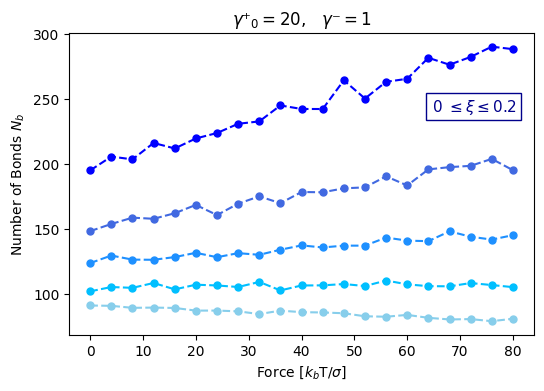

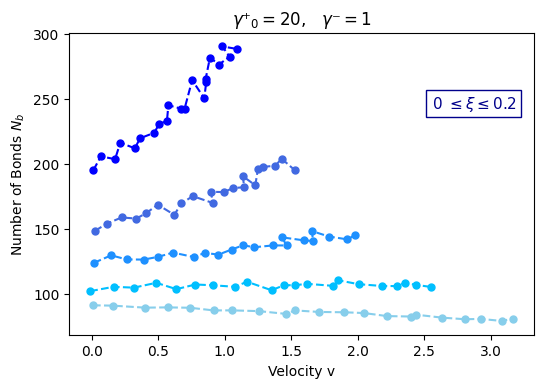

In [257]:
fig = plt.figure(figsize = (6,4), dpi = 100)

for x in lst:
    plt.rc('axes', prop_cycle=(cycler('color', colors_blues)))
    plt.plot(forces, [dict.get(f'xi{x}_f{forces[i]}_meanocc')[1] for i in range(0, len(forces))],'o--', markersize = 5, label = f'{x}')

plt.xlabel(r'Force [$k_b$T/$\sigma$]')
plt.ylabel('Number of Bonds $N_b$')
plt.title(r'$\gamma⁺_0 =$' + f'{gp},   ' + r'$\gamma⁻ = 1$', fontsize = 12)
plt.text(0.74, 0.65, r'0 $\leq \xi \leq 0.2$', fontsize = 11, color = 'darkblue', bbox = {'fc' : 'white', 'mutation_aspect':0.75, 'ec':'darkblue'}, transform=ax.transAxes)


#plt.savefig(f"Plots/meanNbvsForce_gp{gp}_gm1_xi0-02_f0-81-4_noreac6e5.jpeg", format = 'jpeg', dpi=300)
plt.show()

fig = plt.figure(figsize = (6,4), dpi = 100)

for x in lst:
    plt.rc('axes', prop_cycle=(cycler('color', colors_blues)))
    plt.plot([dict_velo.get(f'xi{x}_f{forces[i]}_velocity')for i in range(0, len(forces))], [dict.get(f'xi{x}_f{forces[i]}_meanocc')[1] for i in range(0, len(forces))],'o--', markersize = 5, label = f'{x}')

plt.xlabel(r'Velocity v')
plt.ylabel('Number of Bonds $N_b$')
plt.title(r'$\gamma⁺_0 =$' + f'{gp},   ' + r'$\gamma⁻ = 1$', fontsize = 12)
plt.text(0.74, 0.65, r'0 $\leq \xi \leq 0.2$', fontsize = 11, color = 'darkblue', bbox = {'fc' : 'white', 'mutation_aspect':0.75, 'ec':'darkblue'}, transform=ax.transAxes)
#plt.savefig(f"Plots/meanNbvsVelo_gp{gp}_gm1_xi0-02_f0-81-4_noreac6e5.jpeg", format = 'jpeg', dpi=300)
plt.show()

### Plot state Nbu vs. force and vs. velocity

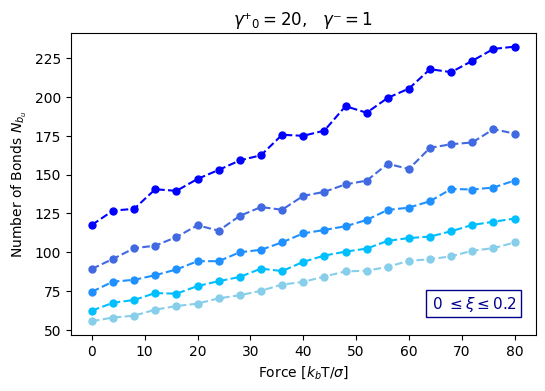

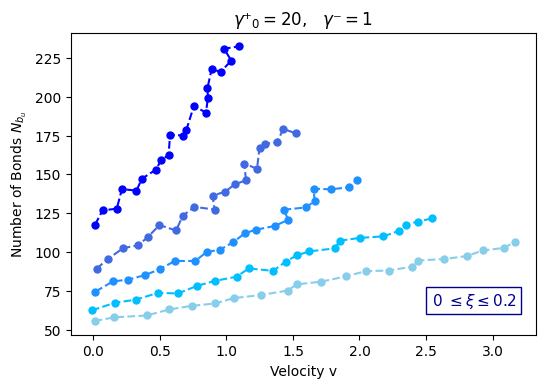

In [259]:
fig = plt.figure(figsize = (6,4), dpi = 100)

for x in lst:
    plt.rc('axes', prop_cycle=(cycler('color', colors_blues)))
    plt.plot(forces, [dict.get(f'xi{x}_f{forces[i]}_meanocc')[3] for i in range(0, len(forces) )],'o--', markersize = 5)
    
plt.text(0.74, 0.12, r'0 $\leq \xi \leq 0.2$', fontsize = 11, color = 'darkblue', bbox = {'fc' : 'white', 'mutation_aspect':0.75, 'ec':'darkblue'}, transform=ax.transAxes)
plt.xlabel(r'Force [$k_b$T/$\sigma$]')
plt.ylabel('Number of Bonds $N_{b_u}$')
plt.title(r'$\gamma⁺_0 =$' + f'{gp},   ' + r'$\gamma⁻ = 1$', fontsize = 12)
#plt.savefig(f"Plots/meanNbuvsForce_gp{gp}_gm1_xi0-02_f0-81-4_noreac6e5.jpeg", format = 'jpeg', dpi=300)
plt.show()

fig = plt.figure(figsize = (6,4), dpi = 100)
for x in lst:
    plt.rc('axes', prop_cycle=(cycler('color', colors_blues)))
    plt.plot([dict_velo.get(f'xi{x}_f{forces[i]}_velocity')for i in range(0, len(forces))], [dict.get(f'xi{x}_f{forces[i]}_meanocc')[3] for i in range(0, len(forces) )],'o--', markersize = 5)
    
plt.text(0.74, 0.12, r'0 $\leq \xi \leq 0.2$', fontsize = 11, color = 'darkblue', bbox = {'fc' : 'white', 'mutation_aspect':0.75, 'ec':'darkblue'}, transform=ax.transAxes)
plt.xlabel(r'Velocity v')
plt.ylabel('Number of Bonds $N_{b_u}$')
plt.title(r'$\gamma⁺_0 =$' + f'{gp},   ' + r'$\gamma⁻ = 1$', fontsize = 12)
#plt.savefig(f"Plots/meanNbuvsVelo_gp{gp}_gm1_xi0-02_f0-81-4_noreac6e5.jpeg", format = 'jpeg', dpi=300)
plt.show()

## 5. Compare to analytics: mean occupation number vs. velocity in steady state

#### Taylor expansion of macroscopic equations up to 6th order
where the velocity v is the variable of the function. Xi and the state are chosen in the function CorrectiontermsState

In [221]:
def Expansion_state(v, xi, state):
    v0 = sigma_b
    N0 = dict_analytic.get(f'xi{xi}-gp{gp}-gm{gm}')[0][state]
    N1 = dict_analytic.get(f'xi{xi}-gp{gp}-gm{gm}')[1][state]
    N2 = dict_analytic.get(f'xi{xi}-gp{gp}-gm{gm}')[2][state]
    N3 = dict_analytic.get(f'xi{xi}-gp{gp}-gm{gm}')[3][state]
    N4 = dict_analytic.get(f'xi{xi}-gp{gp}-gm{gm}')[4][state]
    N5 = dict_analytic.get(f'xi{xi}-gp{gp}-gm{gm}')[5][state]
    N6 = dict_analytic.get(f'xi{xi}-gp{gp}-gm{gm}')[6][state]
    return N0 + (v/v0) * N1 + (v/v0)**2/2 * N2 + (v/v0)**3/6 * N3 \
            + (v/v0)**4/24 * N4 + (v/v0)**5/120 * N5 + (v/v0)**6/720 * N6 

#### Choose $\xi$

In [222]:
xi = 0.2

In [223]:
def CorrectiontermsState0(v):
    return Expansion_state(v, xi, 0)
def CorrectiontermsState1(v):
    return Expansion_state(v, xi, 1)
def CorrectiontermsState2(v):
    return Expansion_state(v, xi, 2)
def CorrectiontermsState3(v):
    return Expansion_state(v, xi, 3)

#### Computation of the analytic graph

In [224]:
v_lst = np.linspace(0,4, 1000)

y_data_Nb = list(map(CorrectiontermsState1, v_lst))
y_data_Nbu = list(map(CorrectiontermsState3, v_lst))
y_data_Na = list(map(CorrectiontermsState0, v_lst))
y_data_Nau = list(map(CorrectiontermsState2, v_lst))

#### Add x axis for Force

In [225]:
f_axis = [20, 40, 60, 80]
v_axis = [dict_velo.get(f'xi{xi}_f{f_axis[i]}_velocity')for i in range(0, len(f_axis))]

#### Plot all States

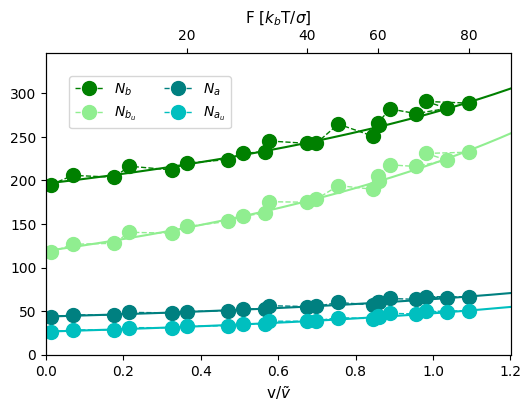

gp = 20,
gm = 1,
xi = 0.2


In [227]:
fig = plt.figure(figsize = (6,4), dpi = 100)
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()


ax1.plot([dict_velo.get(f'xi{xi}_f{forces[i]}_velocity')for i in range(0, len(forces))], [dict.get(f'xi{xi}_f{forces[i]}_meanocc')[1] for i in range(0,len(forces))] ,'o--', linewidth = 1,markersize = 10, color = 'g', label = r'$N_{b}$')
ax1.plot(v_lst, y_data_Nb,color = 'g')

ax1.plot([dict_velo.get(f'xi{xi}_f{forces[i]}_velocity')for i in range(0, len(forces))], [dict.get(f'xi{xi}_f{forces[i]}_meanocc')[3] for i in range(0,len(forces))] ,'o--', linewidth = 1, markersize = 10, color = 'lightgreen', label = r'$N_{b_u}$')
ax1.plot(v_lst, y_data_Nbu,color = 'lightgreen')

ax1.plot([dict_velo.get(f'xi{xi}_f{forces[i]}_velocity')for i in range(0, len(forces))], [dict.get(f'xi{xi}_f{forces[i]}_meanocc')[0] for i in range(0,len(forces))] ,'o--', linewidth = 1, markersize = 10, color = 'teal', label =r'$N_{a}$')
ax1.plot(v_lst, y_data_Na,color = 'teal')

ax1.plot([dict_velo.get(f'xi{xi}_f{forces[i]}_velocity')for i in range(0, len(forces))], [dict.get(f'xi{xi}_f{forces[i]}_meanocc')[2] for i in range(0,len(forces))] ,'o--', linewidth = 1, markersize = 10, color = 'c', label = r'$N_{a_u}$')
ax1.plot(v_lst, y_data_Nau,color = 'c')


ax1.legend(loc = (.05, .75), ncol = 2)
#ax1.text(.92, 0.3 ,r'$\gamma⁺_0 =$' + f'{gp},      '+ "\n" + r'$\gamma⁻ = 1,      $' + '\n' + r'$\xi = $' + f'{xi} ', fontsize = 11, bbox = {'fc' : 'lightgrey', 'mutation_aspect':0.2, 'ec':'lightgrey'}, transform=ax.transAxes)

ax1.set_xlabel(r'v/$\tilde{v}$', fontsize = 11)


ax1.set_xlim([0, 1.1*dict_velo.get(f'xi{xi}_f{forces[-1]}_velocity')])
ax1.set_ylim([0, 1.2*max([dict.get(f'xi{xi}_f{forces[-1]}_meanocc')[i] for i in range(0, 4)])])


ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(v_axis)
ax2.set_xticklabels(f_axis)
ax2.set_xlabel(r'F [$k_b$T/$\sigma$]', fontsize = 11)


#plt.savefig(f'Comparison_NvsVel_Python_Analytics_gp{gp}_gm{gm}_xi{xi}_6thOrder.jpeg', format = 'jpeg', dpi = 300)
plt.show()

print(f'gp = {gp},'+ "\n" + f'gm = {gm},' + '\n' + f'xi = {xi}' )

## 6. Correction terms up to 6th order

In [ ]:
dict_new = {}

dict_new['xi0-gp10-gm1'] = [[10., 44.8169, 6.06531, 27.1828],[0, -3.83173, 5.05798, 26.6065], [0, -12.096, 5.25897, 23.753], [0, 3.93792, 0.0901243, -11.5064],[0, -512.514, -164.289, -866.493], [0, -954.258, -251.866, -895.418], [0, 220672., 51201.6, 283000. ]]
dict_new['xi0.05-gp10-gm1'] = [[11.5729, 51.8662, 7.01933, 31.4585],[1.78174, 3.55075, 6.93424, 35.6347], [2.13928, -5.77645, 9.1861, 42.7855], [0.952208, -0.0998707, 6.73899, 19.0442],[-56.1497, -858.953, -215.446, -1122.99],[-147.969, -2119.61, -664.391, -2959.38],[18481.5, 336912., 68776.5, 369629.]]
dict_new['xi0.1-gp10-gm1'] =  [[13.733, 61.5471, 8.3295, 37.3302],[5.01787, 17.2264, 9.98963, 50.1787], [8.14666, 16.0539, 17.2394, 81.4666], [11.6705, 30.1379, 27.4806, 116.705], [-133.587, -1371.64, -257.144, -1335.87], [-686.283, -5525.21, -1450.06, -6862.83], [49353.3, 519193., 94349.2, 493533.]]
dict_new['xi0.15-gp10-gm1'] = [[16.8845, 75.6713, 10.241, 45.8969],[11.3778, 44.5219, 15.4411, 75.8518], [25.4915, 85.1022, 35.8506, 169.943], [67.1466, 236.989, 97.5099, 447.644],[-110.801, -1631.93, -127.902, -738.676],[-1675.03, -12533.3, -2300.63, -11166.8],[102917., 814114., 134927., 686112.]]
dict_new['xi0.2-gp10-gm1'] = [[21.9133, 98.2086, 13.2911, 59.5666],[25.5525, 106.122, 26.5821, 127.762],[82.4041, 323.221, 87.3536, 412.021], [357.018, 1421.22, 382.094, 1785.09],[1296.23, 3581.2, 1409.45, 6481.14],[5146.75, 7949.66, 5633.87, 25733.8],[271482., 1.58974*10**6, 278602., 1.35741*10**6]]

dict_new['xi0-gp20-gm1'] = [[20., 89.6338, 12.1306, 54.3656],[0, -7.66347, 10.116, 53.2129], [0, -24.192, 10.5179, 47.5061], [0, 7.809, 0.0901243, -23.3473], [0, -1025.03, -328.577, -1732.99], [0, -1908.52, -503.731, -1790.84],[0, 441344., 102403., 566000.]]
dict_new['xi0.05-gp20-gm1'] = [[23.1458, 103.732, 14.0387, 62.9169],[3.56347, 7.1015, 13.8685, 71.2694], [4.27855, -11.5529, 18.3722, 85.571], [1.90442, -0.199741, 13.478, 38.0883], [-112.299, -1717.91, -430.891, -2245.99], [-295.938, -4239.21, -1328.7, -5918.77], [36962.9, 673824., 137553., 739259.]]
dict_new['xi0.1-gp20-gm1'] =  [[27.466, 123.094, 16.659, 74.6605],[10.0357, 34.4528, 19.9793, 100.357], [16.2933, 32.1078, 34.4788, 162.933], [23.341, 60.2758, 54.9612, 233.41], [-267.174, -2743.28, -514.289, -2671.74], [-1372.57, -11050.4, -2900.12, -13725.7], [98706.5, 1.03839*10**6, 188698., 987065.]]
dict_new['xi0.15-gp20-gm1'] = [[33.7691, 151.343, 20.482, 91.7939],[22.7555, 89.0438, 30.8823, 151.704], [50.983, 170.204, 71.7012, 339.887], [134.293, 473.977, 195.02, 895.288],[-221.603, -3263.87, -255.804, -1477.35],[-3350.05, -25066.7, -4601.27, -22333.7],[205833., 1.62823*10**6, 269854., 1.37222*10**6]]
dict_new['xi0.2-gp20-gm1'] = [[43.8266, 196.417, 26.5822, 119.133],[51.105, 212.243, 53.1642, 255.525],[164.808, 646.443, 174.707, 824.041], [714.037, 2842.45, 764.187, 3570.18],[2592.46, 7162.4, 2818.89, 12962.3],[10293.5, 15899.3, 11267.7, 51467.5], [542964., 3.17949*10**6, 557204., 2.71482*10**6]]

#with open(f'OrderCorrections_gp10-20_gm1.pkl', 'wb') as f:
    #pickle.dump(dict_new, f)

## 7. Plot Trajectories for varying  $\xi$ and a given Force
Allwos to evaltuate the transition between steady state and exp. growth in simulations. Use the jupyter notebook 'HorizontalModel-ParallelizedXi.ipynb' to generate data

#### Load dictionary

In [ ]:
#with open('#insert data here#.pkl', 'rb') as f:
 #   dict_trans = pickle.load(f)

In [ ]:
print(dict_trans.keys())

#### Plot

In [ ]:
forces = [10, 20]
lst = [i/1000 for i in range(680, 745, 4)]
f = 10
state = 3
states_label = [r'$n_a$', r'$n_b$', r'$n_{a_u}$', r'$n_{b_u}$']


for j in lst:
    plt.plot(dict_trans.get(f'xi{j}_f{f}_time'), dict_trans.get(f'xi{j}_f{f}_occ')[state], color = 'darkorange', label= states_label[state])
    plt.xlabel(r'Time / [$k_{\beta}$]')
    plt.ylabel(r'$N_{b_u}$')
    plt.text(0, 0.92 * np.amax(dict_trans.get(f'xi{j}_f{f}_occ')[state]), r'$\xi$ ' + f'= {j} ,  F = {f}' , fontsize = 12)
    plt.savefig(f'Plots/Transition_gp10_gm2/F10/Transition_gp10_gm1_Nbu-vs-time_xi{j}_f{f}_noreac1e6.svg', format = 'svg', dpi=300)
    plt.show()

## 8. Plot Trajectories for varying $\xi$ and Force Steps
Use the jupyter notebook 'HorizontalModel-ForceSteps.ipynb' to generate data

#### Load Dictionary

In [263]:
#with open('#insert data here#.pkl', 'rb') as f:
 #   dict_trans = pickle.load(f)

### Plot

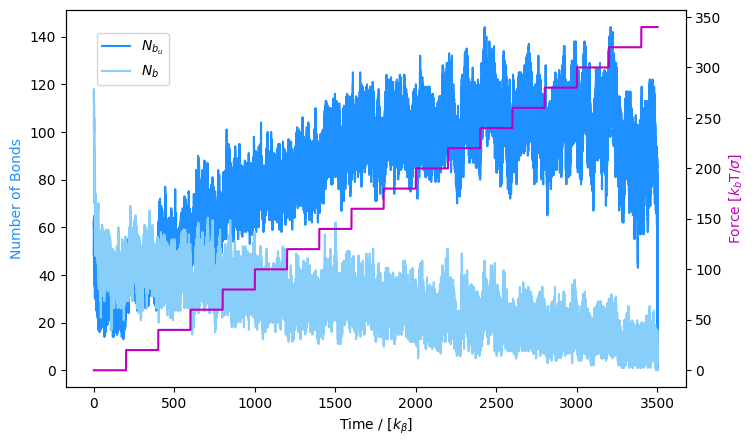

In [265]:
xi = 0
fig, ax1 = plt.subplots(figsize = (8,5), dpi = 100)

ax2 = ax1.twinx()
ax1.plot(dict_forcestep.get(f'xi{xi}_time')[0:-1], dict_forcestep.get(f'xi{xi}_occ')[3], color = 'dodgerblue', label=r'$N_{b_u}$' )
ax1.plot(dict_forcestep.get(f'xi{xi}_time')[0:-1], dict_forcestep.get(f'xi{xi}_occ')[1], color = 'lightskyblue', label=r'$N_{b}$')
ax2.plot(dict_forcestep.get(f'xi{xi}_time'), dict_forcestep.get(f'xi{xi}_force'), color ='m')

ax1.set_xlabel(r'Time / [$k_{\beta}$]')
ax1.set_ylabel('Number of Bonds', color='dodgerblue')
ax1.legend(loc = (0.05, 0.8))
ax2.set_ylabel(r'Force [$k_b$T/$\sigma$]', color='m')
#fig.title(r'$\xi$' + f'= {xi}', fontsize = 14)
#fig.savefig(f'NB-vs-time_gp{gp}_gm{gm}_xi{xi}_f{forces[0]}_fstep{fstep}_tinterval{t_intervall}.jpeg', format = 'jpeg', dpi=100)
plt.show()